# TREINAMENTO REDE EFFICIENTNET v3.2EF.30e.2Sl

**Rede:** Efficient Net

> Com os pesos congelados

**Dataset:** Selected Localized

> Epochs = 30

> Batch = 32

> Target = (100, 100)

> SEED = 10

> CLUSTERIZAÇÃO? Não

**Obs.:** Com separação de indivíduo

In [1]:
!nvidia-smi

Tue Sep 17 12:43:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ['TF_DISABLE_JIT'] = '1'

In [3]:
!jupyter notebook --NotebookApp.iopub_msg_rate_limit=1.0e10

[I 12:43:24.897 NotebookApp] [nb_conda_kernels] enabled, 1 kernels found
[I 12:43:25.013 NotebookApp] Writing notebook server cookie secret to /root/.local/share/jupyter/runtime/notebook_cookie_secret

  _   _          _      _
 | | | |_ __  __| |__ _| |_ ___
 | |_| | '_ \/ _` / _` |  _/ -_)
  \___/| .__/\__,_\__,_|\__\___|
       |_|
                       
Read the migration plan to Notebook 7 to learn about the new features and the actions to take if you are using extensions.

https://jupyter-notebook.readthedocs.io/en/latest/migrate_to_notebook7.html

Please note that updating to Notebook 7 might break some of your extensions.

[I 12:43:25.436 NotebookApp] Registered dataproc_jupyter_plugin server extension
jupyter_http_over_ws extension initialized. Listening on /http_over_websocket
[I 12:43:25.975 NotebookApp] Skipped non-installed server(s): bash-language-server, dockerfile-language-server-nodejs, javascript-typescript-langserver, jedi-language-server, julia-language-server, pyr

## Bibliotecas e Constantes

In [4]:
!pip install tensorflow[and-cuda]

  Preparing metadata (setup.py) ... - \ done
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.5/197.5 MB 8.0 MB/s eta 0:00:00

In [5]:
!pip install efficientnet

!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 758.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 820.6 kB/s eta 0:00:00


In [6]:
#------------------------------------------------------------------------------
# BIBLIOTECAS

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
import random

# BIBLIOTECAS DEEP LEARNING
import datetime
import tensorflow as tf
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing import image
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

from efficientnet.tfkeras import EfficientNetB7

#------------------------------------------------------------------------------
# CONSTANTES

DATASET_TYPE = ['cleaned', 'selected', 'selected-localized']
DATASET_TYPE = DATASET_TYPE[2] # Dataset utilizado no treinamento

DATASET_COMPLETO = True

CNN_MODEL = 'efficient-net' # Rede utilizada no treinamento

SEED = 10
np.random.seed(SEED) # semente geradora dos numeros aleatorios
random.seed(SEED)
tf.random.set_seed(SEED)

N_FOLDS = 5
N_EPOCHS = 30
BATCH_SIZE = 32
SIZE = 100
TARGET_SIZE = (SIZE, SIZE)

VERSION = '2.1EF.30e.2SL'

2024-09-17 12:46:51.018478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 12:46:51.039479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 12:46:51.045979: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Diretórios e Carregamentos de Dados

In [7]:
# Criando pasta de resultados
if not os.path.exists(f'{DATASET_TYPE}'):
    os.mkdir(f'{DATASET_TYPE}')

In [8]:
#------------------------------------------------------------------------------
# DIRETÓRIOS DOS DATASETS

DATASET_PATH = f'/kaggle/input/myocardits-dataset-selected-localized/'
RESULTS_PATH = f'/kaggle/working/{DATASET_TYPE}'

NORMAL_PATH = DATASET_PATH + '/Normal/'
SICK_PATH = DATASET_PATH + '/Sick/'

# Diretorios de cada Individuo:
normal_datasets = [f'{NORMAL_PATH}Individuo_{i:02}/' for i in range(1, 17)]
sick_datasets = [f'{SICK_PATH}Individuo_{i:02}/' for i in range(17, 48)]

print(normal_datasets)
print(sick_datasets)

NORMAL_SPLITS = [[9, 10, 12, 15],
                 [1,8,11],
                 [4,5,14],
                 [2,7,13],
                 [3,6,16]]

if DATASET_COMPLETO == True:
    SICK_SPLITS = [[21,23,26,27,36,38],
                   [18,37,39,40,41,45,46],
                   [20,24,28,29,31,32],
                   [19,22,30,33,42,47],
                   [17,25,34,35,43,44]]

normal_splits = [[],[],[],[],[]]
sick_splits = [[],[],[],[],[]]

for split in range(N_FOLDS):
    normal_splits[split].extend(normal_datasets[i-1] for i in NORMAL_SPLITS[split])
    sick_splits[split].extend(sick_datasets[i-17] for i in SICK_SPLITS[split])

['/kaggle/input/myocardits-dataset-selected-localized//Normal/Individuo_01/', '/kaggle/input/myocardits-dataset-selected-localized//Normal/Individuo_02/', '/kaggle/input/myocardits-dataset-selected-localized//Normal/Individuo_03/', '/kaggle/input/myocardits-dataset-selected-localized//Normal/Individuo_04/', '/kaggle/input/myocardits-dataset-selected-localized//Normal/Individuo_05/', '/kaggle/input/myocardits-dataset-selected-localized//Normal/Individuo_06/', '/kaggle/input/myocardits-dataset-selected-localized//Normal/Individuo_07/', '/kaggle/input/myocardits-dataset-selected-localized//Normal/Individuo_08/', '/kaggle/input/myocardits-dataset-selected-localized//Normal/Individuo_09/', '/kaggle/input/myocardits-dataset-selected-localized//Normal/Individuo_10/', '/kaggle/input/myocardits-dataset-selected-localized//Normal/Individuo_11/', '/kaggle/input/myocardits-dataset-selected-localized//Normal/Individuo_12/', '/kaggle/input/myocardits-dataset-selected-localized//Normal/Individuo_13/'

In [9]:
#------------------------------------------------------------------------------
# CARREGAMENTO DE DADOS COM SEPARAÇÃO DE INDIVIDUOS

print('\nIniciando carregamento e processamento das imagens..............!')

def carregar_imagens(diretorio):
    global num_imagens
    imagens = []
    for pasta_atual, subpastas, arquivos in os.walk(diretorio):
        for arquivo in arquivos:
            if arquivo.endswith(('.jpg', '.jpeg', '.png')):
                caminho = os.path.join(pasta_atual, arquivo)
                
                img = Image.open(caminho)
                img = img.resize(TARGET_SIZE)
                img = img.convert('L')
                img_array = np.array(img)
                imagens.append(img_array)
                
                num_imagens += 1
                sys.stdout.write("\rNumero de imagens carregados: %i" % num_imagens)
                sys.stdout.flush()
                
    return imagens

num_imagens = 0

print('\nPacientes normais:')
normal_groups = []
for diretorios in normal_splits:
    imagens = []
    for individuos in diretorios:
        imagens.extend(carregar_imagens(individuos))
    normal_groups.append(imagens)

num_imagens = 0

print('\n\nPacientes doentes:')
sick_groups = []
for diretorios in sick_splits:
    imagens = []
    for individuos in diretorios:
        imagens.extend(carregar_imagens(individuos))
    sick_groups.append(imagens)

# DATASETS SEPRADAOS EM 5 PARA VALIDAÇÃO CRUZADA    
x_data = [[],[],[],[],[]]
y_data = [[],[],[],[],[]]

print('\n\nNumero de imagens por split:')
for i in range(N_FOLDS):
    x_data[i].extend(path for path in normal_groups[i])
    y_data[i].extend([1, 0] for path in normal_groups[i])
    x_data[i].extend(path for path in sick_groups[i])
    y_data[i].extend([0, 1] for path in sick_groups[i])
    print(f'Split {i+1}: {len(x_data[i])} imagens ({len(normal_groups[i])} saudáveis e {len(sick_groups[i])} doentes).')


Iniciando carregamento e processamento das imagens..............!

Pacientes normais:
Numero de imagens carregados: 137

Pacientes doentes:
Numero de imagens carregados: 257

Numero de imagens por split:
Split 1: 81 imagens (32 saudáveis e 49 doentes).
Split 2: 84 imagens (27 saudáveis e 57 doentes).
Split 3: 76 imagens (26 saudáveis e 50 doentes).
Split 4: 77 imagens (26 saudáveis e 51 doentes).
Split 5: 76 imagens (26 saudáveis e 50 doentes).


## Treinamento

In [10]:
# Arquitetura CNN
def cnn_model(input_shape, num_classes):
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model

In [11]:
#------------------------------------------------------------------------------
# SEPARAÇÃO DE DADOS E TREINAMENTO

lst_accuracy=[]
lst_accuracy_v=[]
lst_acc=[]
lst_loss=[]
lst_reports=[]
lst_AUC=[]
lst_matrix=[]
lst_matrix_v=[]
lst_times=[]
lst_history=[]

#------------------------------------------------------------------------------
# TREINAMENTO POR FOLDS

for fold in range(N_FOLDS):

    print(f'\n\nFOLD {fold+1}:')

    #--------------------------------------------------------------------------
    # CARREGAMENTO DAS IMAGENS DE TREINAMENTO, VALIDACAO E TESTE

    print(f'\nCarregamento das imagens do fold {fold+1} para treinamento.............!')

    folds = [0, 1, 2, 3, 4]

    x_test = np.array(x_data[fold])
    y_test = np.array(y_data[fold])
    folds.remove(fold)

    x_valid = np.array(x_data[folds[0]])
    y_valid = np.array(y_data[folds[0]])
    folds.remove(folds[0])

    x_train, y_train = [], []
    for i in folds:
        x_train.extend(x_data[i])
        y_train.extend(y_data[i])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    x_train = np.stack([x_train] * 3, axis=-1)
    x_valid = np.stack([x_valid] * 3, axis=-1)
    x_test = np.stack([x_test] * 3, axis=-1)
    
    print(f'Numero de imagens no treinamento: {len(x_train)} imagens.')
    print(f'Numero de imagens na validação: {len(x_valid)} imagens.')
    print(f'Numero de imagens no teste: {len(x_test)} imagens.')

    #--------------------------------------------------------------------------
    # ARQUITETURA E COMPILACAO

    model=cnn_model((SIZE, SIZE, 3), 2)
    
    OPTIMIZER = AdamW(weight_decay = 0.004)
    
    # Compilacao do modelo
    model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['categorical_accuracy'])

    #--------------------------------------------------------------------------
    # TREINAMENTO
    print('\nIniciando o treinamento.........................................!\n')

    calback=CSVLogger(RESULTS_PATH + f'/logger_fold{fold+1}.log')

    # Treinando o modelo
    start=datetime.datetime.now()

    history=model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=(x_valid, y_valid), callbacks=[calback])

    end=datetime.datetime.now()
    training_time=end-start

    # Salvamento do modelo
    model.save(RESULTS_PATH + f'/{DATASET_TYPE}-CNN-{fold+1}.h5')

    #--------------------------------------------------------------------------
    # TESTE

    # Testando o modelo
    print("\nTestando imagens................................................!\n")

    # Acuracia e Perda do Teste
    test_loss, test_acc = model.evaluate(x_test, y_test)

    print(model.metrics_names)

    #--------------------------------------------------------------------------
    # ARMAZENAMENTO DOS INFORMACOES

    # Fazendo previsões
    predicts = model.predict(x_test)
    predicts = predicts.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals=y_test.argmax(axis=1)

    # Calculando a curva ROC
    fpr, tpr, _ = roc_curve(actuals, predicts, pos_label=1)
    a = auc(fpr, tpr)

    # Gerando o relatório de classificação
    r = classification_report(actuals, predicts, zero_division=1)

    # Calculando a matriz de confusão
    c = confusion_matrix(actuals, predicts)
    accuracy = np.trace(c)/np.sum(c)
    
    # Validação
    # Fazendo previsões
    predicts_v = model.predict(x_valid)
    predicts_v = predicts_v.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals_v=y_valid.argmax(axis=1)
    
    # Calculando a matriz de confusão
    c_v = confusion_matrix(actuals, predicts)
    accuracy_v = np.trace(c)/np.sum(c)

    lst_history.append(history)
    lst_times.append(training_time)
    lst_accuracy.append(accuracy)
    lst_acc.append(test_acc)
    lst_loss.append(test_loss)
    lst_AUC.append(a)
    lst_reports.append(r)
    lst_matrix.append(c)
    
    lst_accuracy_v.append(accuracy_v)
    lst_matrix_v.append(c_v)



FOLD 1:

Carregamento das imagens do fold 1 para treinamento.............!
Numero de imagens no treinamento: 229 imagens.
Numero de imagens na validação: 84 imagens.
Numero de imagens no teste: 81 imagens.


I0000 00:00:1726577227.225650      24 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726577227.226067      24 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726577227.621615      24 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726577227.621916      24 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

258434480/258434480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30


I0000 00:00:1726577266.854456     136 service.cc:146] XLA service 0x78ac300fb980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726577266.854499     136 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726577266.854503     136 service.cc:154]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/8 ━━━━━━━━━━━━━━━━━━━━ 7:51 67s/step - categorical_accuracy: 0.5625 - loss: 14.4409

I0000 00:00:1726577302.368381     136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 125s 8s/step - categorical_accuracy: 0.5805 - loss: 168.6541 - val_categorical_accuracy: 0.3452 - val_loss: 3.4498
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - categorical_accuracy: 0.6224 - loss: 944.1002 - val_categorical_accuracy: 0.6310 - val_loss: 4.6455
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - categorical_accuracy: 0.5683 - loss: 845.7913 - val_categorical_accuracy: 0.5833 - val_loss: 3.9510
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - categorical_accuracy: 0.5745 - loss: 680.4534 - val_categorical_accuracy: 0.5119 - val_loss: 2.8001
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - categorical_accuracy: 0.5053 - loss: 874.7513 - val_categorical_accuracy: 0.4643 - val_loss: 2.5672
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - categorical_accuracy: 0.4550 - loss: 1646.6387 - val_categorical_accuracy: 0.5357 - val_loss: 1.8103
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - categorical_accuracy: 0.5749 - loss: 343.9730 - val_c

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step - categorical_accuracy: 0.5390 - loss: 417.1698 - val_categorical_accuracy: 0.6049 - val_loss: 1.2775
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - categorical_accuracy: 0.5275 - loss: 295.2296 - val_categorical_accuracy: 0.5926 - val_loss: 1.0245
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - categorical_accuracy: 0.4635 - loss: 145.1451 - val_categorical_accuracy: 0.6173 - val_loss: 1.3551
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - categorical_accuracy: 0.5782 - loss: 67.4314 - val_categorical_accuracy: 0.6543 - val_loss: 1.1544
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - categorical_accuracy: 0.6404 - loss: 21.0541 - val_categorical_accuracy: 0.6173 - val_loss: 1.3242
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - categorical_accuracy: 0.6603 - loss: 1.0594 - val_categorical_accuracy: 0.6049 - val_loss: 1.4520
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 8s/step - categorical_accuracy: 0.6081 - loss: 102.6352 - val_categorical_accuracy: 0.6173 - val_loss: 1.7244
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - categorical_accuracy: 0.5364 - loss: 215.3931 - val_categorical_accuracy: 0.3580 - val_loss: 2.6521
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - categorical_accuracy: 0.6103 - loss: 115.5017 - val_categorical_accuracy: 0.3457 - val_loss: 2.5392
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - categorical_accuracy: 0.4878 - loss: 293.6654 - val_categorical_accuracy: 0.2716 - val_loss: 3.5504
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - categorical_accuracy: 0.4217 - loss: 139.5177 - val_categorical_accuracy: 0.2963 - val_loss: 4.0765
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - categorical_accuracy: 0.4489 - loss: 202.9962 - val_categorical_accuracy: 0.3827 - val_loss: 3.0743
Epoch 7/30
8/8 ━━━━━━━━━━━

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step - categorical_accuracy: 0.5841 - loss: 326.9060 - val_categorical_accuracy: 0.6543 - val_loss: 4.8440
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - categorical_accuracy: 0.6425 - loss: 350.5311 - val_categorical_accuracy: 0.3210 - val_loss: 3.9218
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - categorical_accuracy: 0.4516 - loss: 242.3673 - val_categorical_accuracy: 0.3951 - val_loss: 1.6578
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - categorical_accuracy: 0.4919 - loss: 156.7227 - val_categorical_accuracy: 0.4815 - val_loss: 1.1723
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - categorical_accuracy: 0.5330 - loss: 128.5571 - val_categorical_accuracy: 0.3951 - val_loss: 1.0966
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - categorical_accuracy: 0.4960 - loss: 69.4920 - val_categorical_accuracy: 0.5926 - val_loss: 0.9839
Epoch 7/30
8/8 ━━━━━━━━━━━━

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 114s 7s/step - categorical_accuracy: 0.4802 - loss: 440.9055 - val_categorical_accuracy: 0.6173 - val_loss: 5.0046
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - categorical_accuracy: 0.6740 - loss: 322.1426 - val_categorical_accuracy: 0.6296 - val_loss: 2.1656
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - categorical_accuracy: 0.5931 - loss: 140.8239 - val_categorical_accuracy: 0.4938 - val_loss: 3.1487
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - categorical_accuracy: 0.5954 - loss: 273.7027 - val_categorical_accuracy: 0.4938 - val_loss: 3.6198
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - categorical_accuracy: 0.6511 - loss: 198.4287 - val_categorical_accuracy: 0.3457 - val_loss: 4.3219
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - categorical_accuracy: 0.5734 - loss: 72.3448 - val_categorical_accuracy: 0.2716 - val_loss: 3.7270
Epoch 7/30
8/8 ━━━━━━━━━━━━

In [12]:
'''from matplotlib import cm
from tensorflow.keras.models import load_model
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize

def visualize_gradcam(model, img_array, image_title):
    # Ensure the input image array has the correct shape and type
    img_array = np.expand_dims(img_array, axis=-1)  # Ensure it has a single channel if needed
    img_array = np.expand_dims(img_array, axis=0)   # Add batch dimension if needed
    img_array = img_array.astype(np.float32)        # Convert to float32 if needed

    # Create Gradcam object
    gradcam = Gradcam(model,
                      model_modifier=None,  # Modify if needed
                      clone=True)

    # Define a função de pontuação (score function)
    def score_function(output):
        return output[:, np.argmax(output[0])]  # Use o índice da classe com maior probabilidade

    # Generate heatmap with GradCAM
    cam = gradcam(score=score_function,
                  penultimate_layer=-1,  # Index of the penultimate layer
                  seed_input=img_array)

    # Process the heatmap for visualization
    heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)  # Apply colormap and convert to uint8
    heatmap = np.squeeze(heatmap)  # Remove single-dimensional entries from the shape of an array

    # Render
    plt.figure(figsize=(6, 4))
    plt.title(image_title, fontsize=16)
    plt.imshow(img_array[0, :, :, 0], cmap='gray', alpha=0.5)  # Show the grayscale image
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Carregar o modelo treinado
model = load_model(RESULTS_PATH + f'/{DATASET_TYPE}-CNN-{fold+1}.h5')

# Imagens de teste
imgs_array = []

caminhos = ['/kaggle/input/myocardits-dataset-cleaned/224/Sick/Individuo_18/series0005-Body/img0013-40.5666.jpg',
            '/kaggle/input/myocardits-dataset-cleaned/224/Normal/Individuo_10/series0001-Body/img0001--9.jpg',
            '/kaggle/input/myocardits-dataset-cleaned/224/Normal/Individuo_01/series0003-Body/img0001--43.937.jpg',
            '/kaggle/input/myocardits-dataset-cleaned/224/Sick/Individuo_35/series0006-Body/img0011-44.8372.jpg']
for caminho in caminhos:
    img = Image.open(caminho)  # Carrega a imagem
    img = img.resize(TARGET_SIZE)  # Redimensiona para 100x100
    img_array = np.array(img)  # Converte para array NumPy
    rgb_array = np.tile(img_array[:, :, np.newaxis], (1, 1, 3))
    imgs_array.append(rgb_array)

for img_array in imgs_array:
    image_title = 'Mapa de Calor'

    # Visualizar com GRAD-CAM
    visualize_gradcam(model, img_array, image_title)'''


"from matplotlib import cm\nfrom tensorflow.keras.models import load_model\nfrom tf_keras_vis.gradcam import Gradcam\nfrom tf_keras_vis.utils import normalize\n\ndef visualize_gradcam(model, img_array, image_title):\n    # Ensure the input image array has the correct shape and type\n    img_array = np.expand_dims(img_array, axis=-1)  # Ensure it has a single channel if needed\n    img_array = np.expand_dims(img_array, axis=0)   # Add batch dimension if needed\n    img_array = img_array.astype(np.float32)        # Convert to float32 if needed\n\n    # Create Gradcam object\n    gradcam = Gradcam(model,\n                      model_modifier=None,  # Modify if needed\n                      clone=True)\n\n    # Define a função de pontuação (score function)\n    def score_function(output):\n        return output[:, np.argmax(output[0])]  # Use o índice da classe com maior probabilidade\n\n    # Generate heatmap with GradCAM\n    cam = gradcam(score=score_function,\n                  penulti

## Salvamento de Dados

In [13]:
#--------------------------------------------------------------------------
# SALVAMENTO DOS DADOS

print('\nSalvando informações da rede......................................!')

path = RESULTS_PATH + f'/results-v{VERSION}.txt'
    
matrix_total = np.sum(lst_matrix, axis=0)
accuracy_total = np.trace(matrix_total)/np.sum(matrix_total)

matrix_total_v = np.sum(lst_matrix_v, axis=0)
accuracy_total_v = np.trace(matrix_total_v)/np.sum(matrix_total_v)
    
losses=[]
val_losses=[]
accuracies=[]
val_accuracies=[]

for item in lst_history:
    
    history=item.history
    loss=history['loss']
    accuracy=history['categorical_accuracy']
    
    val_loss=history['val_loss']
    val_accuracy=history['val_categorical_accuracy']
    
    losses.append(sum(loss)/len(loss))
    accuracies.append(sum(accuracy)/len(accuracy))
    
    val_losses.append(sum(val_loss)/len(val_loss))
    val_accuracies.append(sum(val_accuracy)/len(val_accuracy))

f1=open(path,'w')
f1.write(f'TREINAMENTO v{VERSION}\n')

f1.write('\nTest Accuracias: '+str(lst_acc)+'\nTest Losses: '+str(lst_loss))
f1.write('\n\nTest Accuracies Mean: '+str(np.mean(lst_acc)))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nValid Accuracies: '+str(val_accuracies)+'\nValid Losses: '+str(val_losses))
f1.write('\n\nValid Accuracies Mean: '+str(np.mean(val_accuracies)))

f1.write('\n\n__________________________________________________________\n')

f1.write('\nAccuracies from Confusion Matrix: '+str(lst_accuracy))

f1.write('\n\nTotal Confusion Matrix: \n'+str(matrix_total)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix: '+str(accuracy_total))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nTotal Confusion Matrix Valid: \n'+str(matrix_total_v)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix Valid: '+str(accuracy_total_v))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nMetrics for all Folds: \n\n')
for i in range(len(lst_reports)):
    f1.write(str(lst_reports[i]))
    f1.write('\n\nTraining Time: '+str(lst_times[i])+'\nAUC: '+str(lst_AUC[i]))
    f1.write('\n\nAcurácia: ' + str(lst_accuracy[i]))
    f1.write('\n\nMatriz de Confusao: \n'+str(lst_matrix[i])+'\n\n__________________________________________________________\n')
f1.close()


Salvando informações da rede......................................!


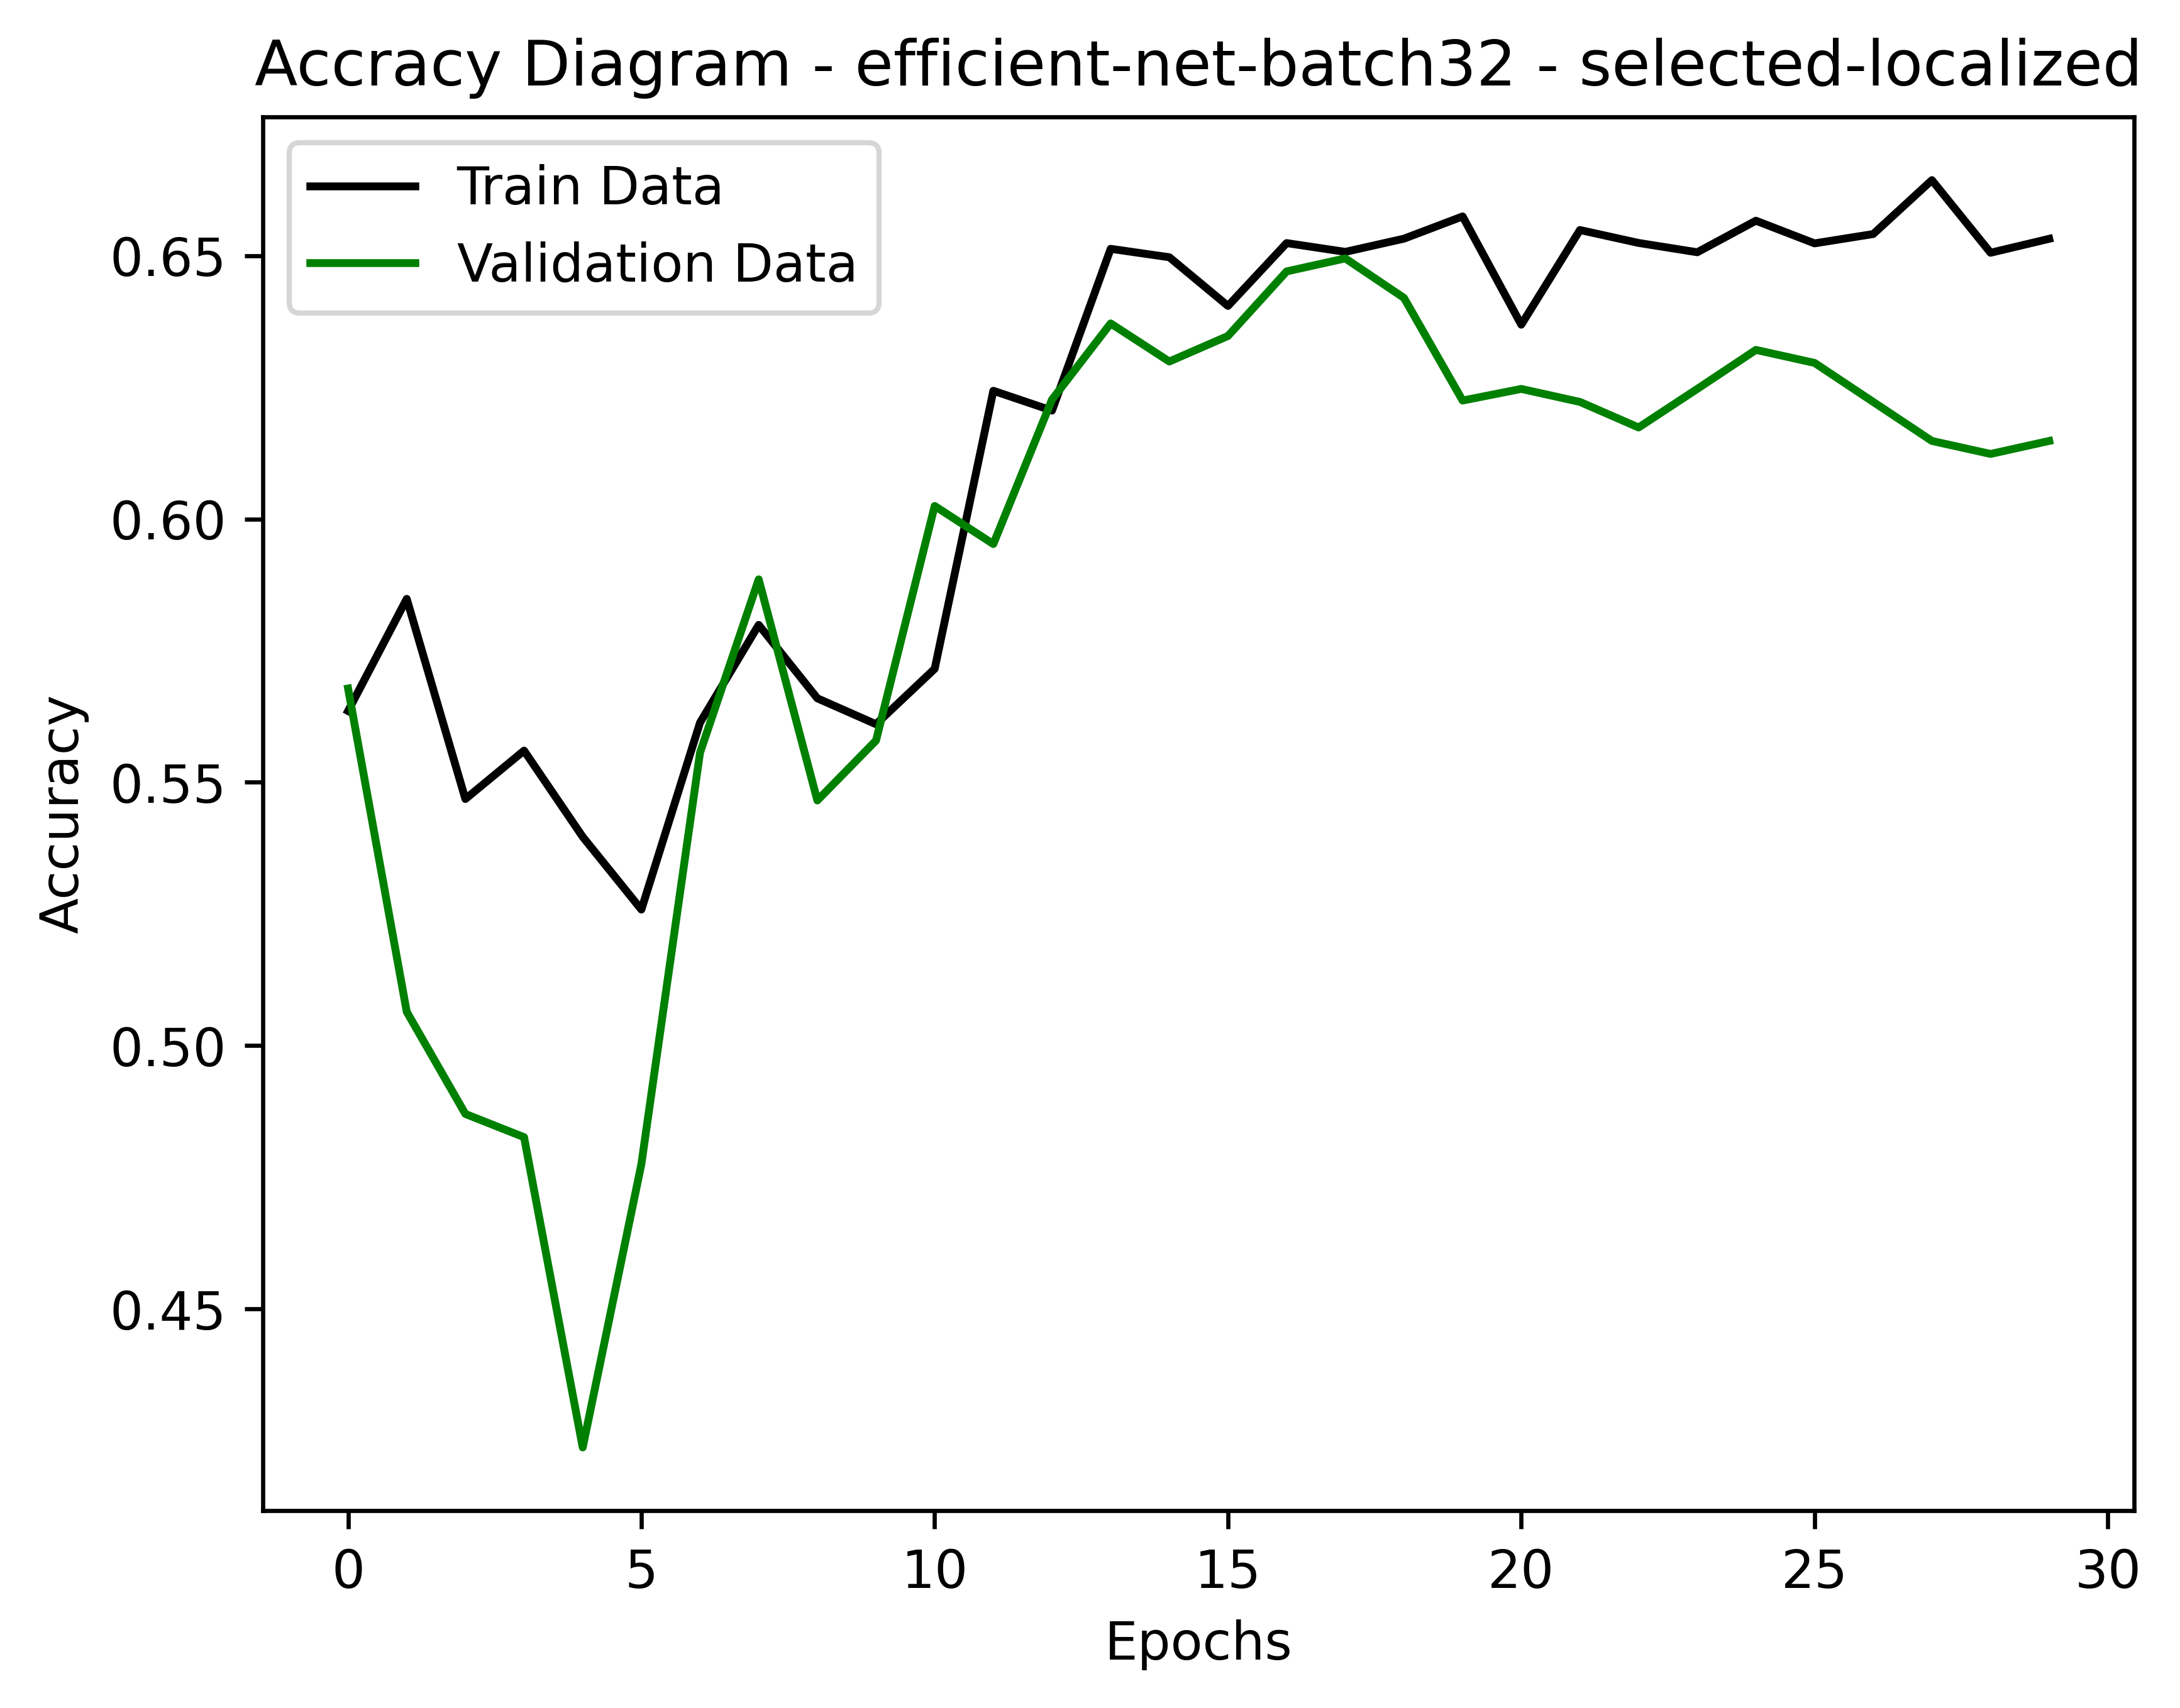

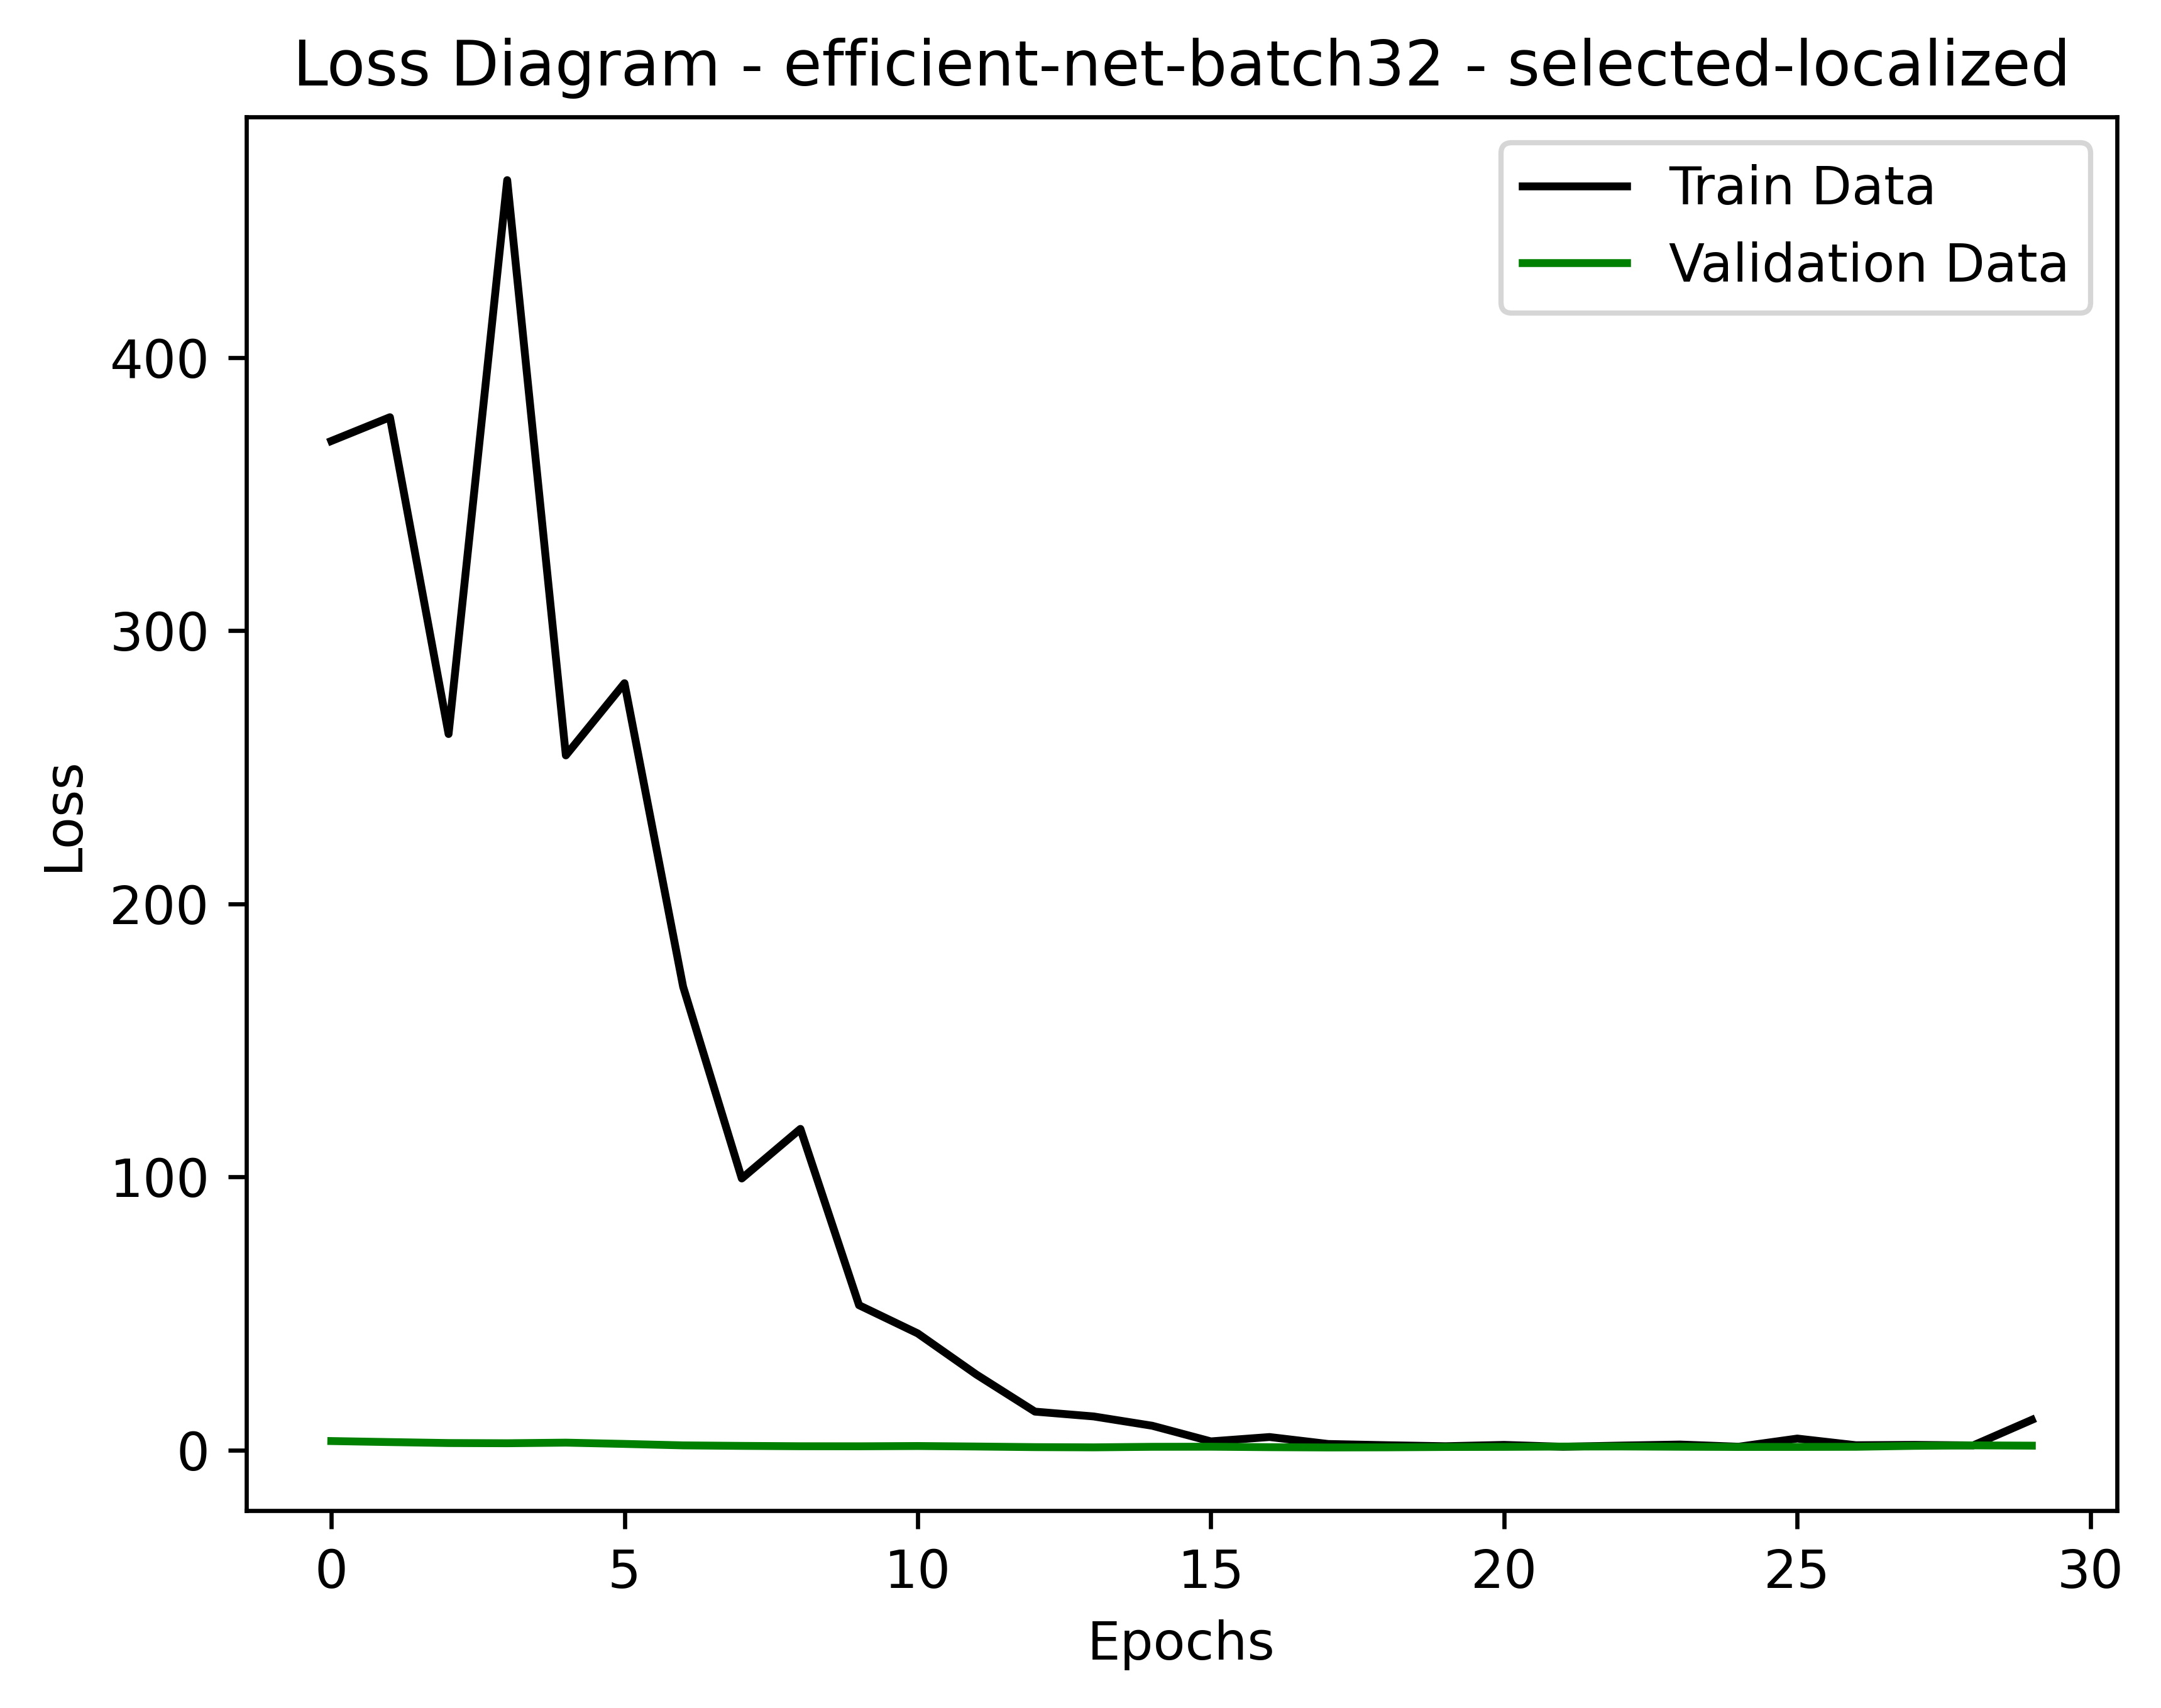

In [14]:
def NetPlot(net_histories,n_epch):
    import numpy as np
    import matplotlib.pyplot as plt

    losses=[]
    val_losses=[]
    accuracies=[]
    val_accuracies=[]

    for item in net_histories:

        history=item.history
        loss=history['loss']
        val_loss=history['val_loss']
        accuracy=history['categorical_accuracy']
        val_accuracy=history['val_categorical_accuracy']

        losses.append(loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)


    losses2=np.zeros((1,n_epch))
    val_losses2=np.zeros((1,n_epch))
    accuracies2=np.zeros((1,n_epch))
    val_accuracies2=np.zeros((1,n_epch))

    for i in losses:
        losses2+=i

    for i in val_losses:
        val_losses2+=i

    for i in accuracies:
        accuracies2+=i

    for i in val_accuracies:
        val_accuracies2+=i
        
    N_SPLITS = 5

    # 10 is number of folds
    losses2=(losses2/N_SPLITS).flatten()
    accuracies2=(accuracies2/N_SPLITS).flatten()
    val_losses2=(val_losses2/N_SPLITS).flatten()
    val_accuracies2=(val_accuracies2/N_SPLITS).flatten()
    
    # print('\nAccuracies: '+ str(accuracies2) +'\nLosses: '+ str(losses2))

    plt.figure('Accracy Diagram',dpi=600)
    plt.title(f'Accracy Diagram - {CNN_MODEL}-batch{BATCH_SIZE} - {DATASET_TYPE}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(accuracies2,color='black')
    plt.plot(val_accuracies2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig(f'{RESULTS_PATH}/Accuracy-Diagram-{CNN_MODEL}-batch{BATCH_SIZE}.jpg')

    plt.figure('Loss Diagram',dpi=600)
    plt.title(f'Loss Diagram - {CNN_MODEL}-batch{BATCH_SIZE} - {DATASET_TYPE}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(losses2,color='black')
    plt.plot(val_losses2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig(f'{RESULTS_PATH}/Loss-Diagram-{CNN_MODEL}-batch{BATCH_SIZE}.jpg')
    
NetPlot(lst_history,N_EPOCHS)

In [15]:
# Zipando pasta com resultados
import zipfile

def compactar_pasta(pasta, nome_arquivo_zip):
    with zipfile.ZipFile(nome_arquivo_zip, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        for root, _, files in os.walk(pasta):
            for arquivo in files:
                caminho_completo = os.path.join(root, arquivo)
                zip_file.write(caminho_completo, os.path.relpath(caminho_completo, pasta))

nome_arquivo_zip = f'{VERSION}-results.zip'
compactar_pasta(RESULTS_PATH, nome_arquivo_zip)